In [1]:
import numpy as np 
import copy
import scipy.optimize as opt
import emcee
import corner

In [2]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 13}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 

## Bayesian Inference and Markov Chain Monte Carlo for Seismology

In this problem, you will use Bayesian inference and Markov chain Monte Carlo (MCMC) to find the parameters of
a model that is used in seismology. The model is given by 
$$
v(x) = \frac{v_{0}}{\pi} \arctan \left(\frac{x-x_{0}}{D}\right)
$$
describes the velocity as a function of a spatial variable $x$ where $v_{0}$ is the fault slip rate, $D$ is the
locking depth, $x_{0}$ is the fault location. You are given measurements of the velocity $v$ at several locations $x$. Thus, your data is $d = \{d_{1},d_{2},...,d_{n}\}$ where
$d_{i} = [x_{i},v_{i}]$. You can download these from canvas (relevant file is *HW2Data.txt*). The first column
contains the locations of the measurements (the $x_{j}$’s) and the second column lists the velocities
(the $v_{j}$’s). There are a total of $n = 200$ measurements.

In [4]:
def model(theta, x):
    # the parameters are stored as a vector of values, so unpack them
    v0, D, x0 = theta
    return (v0/np.pi) * np.arctan((x-x0)/D)

The spatial domain is $x \in [−100,100]$ (in km), the fault slip rate is $v_{0} \in [0,80]$ (in mm/year), the
locking depth is $D \in [0,80]$ (in km) and the fault location is $x_{0} \in [−50,50]$ (in km).

Your knowledgeable seismology friends tell you that a simple Gaussian
error model is appropriate. This means that at a given location $x_{j}$, the observations satisfies
$$
d_{j} = v(x_{j}) + \eta_j,
$$
where $\eta_j  \in \mathcal{N}(0,1)$ and all $\eta_j$ are independent and identically distributed (i.i.d.).

You are tasked with finding model parameters $(v_{0}, D , x_{0})$ so that the output of your model
is compatible with the data you have. You may want to follow the below steps to answer this
question.


#### 1. Formulate the Bayesian posterior distribution for the model parameters $\theta = [v_{0},D,x_{0}]$ given the above information.


The prior is given by 
$$
\mathbb{P}(\theta) = \mathbb{P}(v_{0})\mathbb{P}(D)\mathbb{P}(x_{0}) = \left\{
\begin{array}{ll}
      \frac{1}{100\cdot 80\cdot 80} & -50 \leq x_{0} \leq 50 \qquad \text{and} \qquad 0 \leq D \leq 80 \qquad \text{and} \qquad 0 \leq v_{0} \leq 80 \\
      0 & \text{otherwise} \\
\end{array} 
\right. 
$$
since the uncertain parameters $v_{0}, D, x_{0}$ are independent.
    
The posterior is given by (from Bayes' rule):
$$
\mathbb{P}(\theta | d) = \frac{\mathbb{P}(d|\theta) \mathbb{P}(\theta)}{\mathbb{P}(d)} = \frac{\mathbb{P}(d|\theta) \mathbb{P}(\theta)}{\int_{\mathbb{R}^{3}} \mathbb{P}(d|\theta)\mathbb{P}(\theta)\text{d}\theta} \propto \mathbb{P}(d|\theta) \mathbb{P}(\theta) 
$$

The log-posterior is given by 
$$
\log{\mathbb{P}(\theta | d)} \propto \log{\left[\mathbb{P}(d|\theta) \mathbb{P}(\theta)\right]} = \log{\mathbb{P}(d|\theta)} + \log{\mathbb{P}(\theta)}
$$

The log-prior is given by 
$$
\log{\mathbb{P}(\theta)} = \left\{
\begin{array}{ll}
      \log{\frac{1}{100\cdot 80\cdot 80}} & -50 \leq x_{0} \leq 50 \qquad \text{and} \qquad 0 \leq D \leq 80 \qquad \text{and} \qquad 0 \leq v_{0} \leq 80 \\
      -\infty & \text{otherwise} \\
\end{array} 
\right. 
$$

The likelihood function  updates our belief state by measuring the misfit between the data and model predictions with a specific parameter set. Since we assume Gaussian measurement noise wth zero mean, i.e. $\eta_j  \in \mathcal{N}(\mu= 0,\sigma)$, the output $d$ is independent across observations, conditional on the parameters $\theta$, i.e., $d_{1}$ and $d_{2}$ are independent given $\theta_{1}$ and $\theta_{2}$. Using the independence assumption, we can write the likelihood function as 
$$
\mathbb{P}(d|\theta) =  \prod_{i=1}^{n} \frac{1}{\sqrt{2\pi \sigma^2}} \exp \left( - \frac{[d_{i} - v(\theta)]^{2}}{2\sigma^2} \right) =  \frac{1}{(2\pi \sigma^2)^{-n/2}} \exp \left( - \frac{1}{2\sigma^2} \sum_{i=1}^{n} [d_{i} - v(\theta )]^{2}\right).
$$
Then, the log-likelihood is defined as 
$$
\log{\mathbb{P}(d|\theta)} = \log{\frac{1}{(2\pi \sigma^2)^{-n/2}} \exp \left( - \frac{1}{2\sigma^2} \sum_{i=1}^{n} [d_{i} - v(\theta)]^{2}\right)} = \log{\frac{1}{(2\pi \sigma^2)^{-n/2}}} + \log{\exp \left( - \frac{1}{2\sigma^2} \sum_{i=1}^{n} [d_{i} - v(\theta)]^{2}\right)} \\
= -\frac{n}{2} \log{2\pi} - n\log{\sigma} - \frac{1}{2\sigma^2} \sum_{i=1}^{n} [d_{i} - v(\theta) ]^{2}
$$
By setting $\sigma = 1$, we are left with 
$$
\log{\mathbb{P}(d|\theta)} = -\frac{n}{2} \log{2\pi} - \frac{1}{2} \sum_{i=1}^{n} [d_{i} - v(\theta) ]^{2}
$$

In [5]:
def log_prior(theta):
    # the parameters are stored as a vector of values, so unpack them
    v0, D, x0 = theta
    # we are using only uniform priors
    if -50 <= x0 <= 50 and 0 <= D <= 80 and 0 <= v0 <= 80:
        return np.log(1/(100*80*80))
    else:
        return -np.inf

def log_likelihood(theta, x, v):
    # the parameters are stored as a vector of values, so unpack them
    v0, D, x0 = theta
    # model evaluation for specific parameter sample 'theta'
    model_eval = model(theta=theta, x=x)
    # log-likelihood
    lp = -0.5*(len(x)*np.log(2*np.pi) + sum((v - model_eval)**2))
    return lp

def log_posterior(theta, x, v):
    # evaluate prior
    lp = log_prior(theta=theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta=theta, x=x, v=v)

#### 2. Draw samples from the posterior distribution by using a random walk Metropolis (RWM) MCMC sampler. How do you decide that you have run the sampler for “long enough”? How do you decide what an appropriate “stepsize” is for you RWM? How do you initialize your Markov chain? How many samples do you discard (i.e. burn in phase) because you think that early samples are part of the transient (generated before the chain reached stationarity)?


#### 3. Formulate your answer in terms of expected values and standard deviations for the model parameters. You may also want to produce a triangle plot to show correlation (or lack thereof) of the three model parameters.

In [6]:
data = np.loadtxt("HW2Data.txt", dtype='float', delimiter=',')
np.shape(data)

(200, 2)

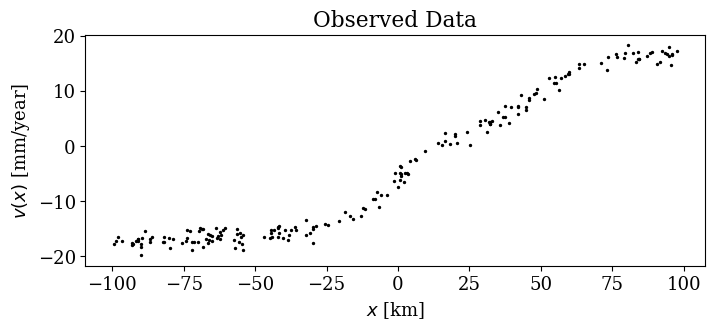

In [7]:
fig, ax = plt.subplots(figsize=(8, 3))
_ = ax.scatter(data[:, 0], data[:, 1], c="k", s=2)
_ = ax.set_xlabel("$x$ [km]")
_ = ax.set_ylabel("$v(x)$ [mm/year]")
_ = ax.set_title("Observed Data")

We initialize the walkers to start close to the log-likelihood maximum, which we find using the scipy.optimization package using the conjugate gradient algorithm.

In [8]:
# we initialize the CG algorithm using the mean of each prior. 
max_log = opt.minimize(fun=lambda *args: -log_likelihood(*args),
                      x0=[40, 40, 0],
                      method="CG",
                      args=(data[:, 0], data[:, 1]))
print(max_log)
initial = max_log["x"]

     fun: 376.8755646622094
     jac: array([0.00000000e+00, 7.62939453e-06, 7.62939453e-06])
 message: 'Optimization terminated successfully.'
    nfev: 288
     nit: 32
    njev: 72
  status: 0
 success: True
       x: array([45.48160872, 35.93942934, 18.34517608])


In [9]:
nwalkers = 5000
nsamples = 2000
ndim = len(initial)
p0 = [np.array(initial) + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]

### MCMC
MCMC is a procedure for generating a random walk in the parameter space that, over time, draws a representative set of samples from the distribution. Each point in a Markov chain $X(t_{i})$ depends only on the position of the previous step $X(t_{i−1})$. 

The MCMC Metropolis-Hastings method involves simultaneously evolving an ensemble of $K$ walkers $S = {X_{k}}$ where the proposal distribution for one walker $k$ is based on the current positions of the $K − 1$ walkers in the complementary ensemble $S_{[k]} = \{X_{j} , \forall j\neq k\}$.




Here, we use a Python implemtation of the affine-invariant ensemble sampler for Markov chain Monte Carlo (MCMC) proposed by Goodman & Weare (2010) descibed in Algotihm 2.

![](alg.png)

In [10]:
def main(p0, nwalkers, niter, ndim, log_posterior, data, nburnin):
    sampler = emcee.EnsembleSampler(nwalkers=nwalkers, ndim=ndim, log_prob_fn=log_posterior, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(initial_state=p0, nsteps=nburnin)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(initial_state=p0, nsteps=niter)

    return sampler, pos, prob, state

In [11]:
sampler, pos, prob, state = main(p0=p0, 
                                nwalkers=nwalkers,
                                niter=nsamples,
                                nburnin=300,
                                ndim=ndim, 
                                log_posterior=log_posterior,
                                data=(data[:, 0], data[:, 1]))

Running burn-in...
Running production...


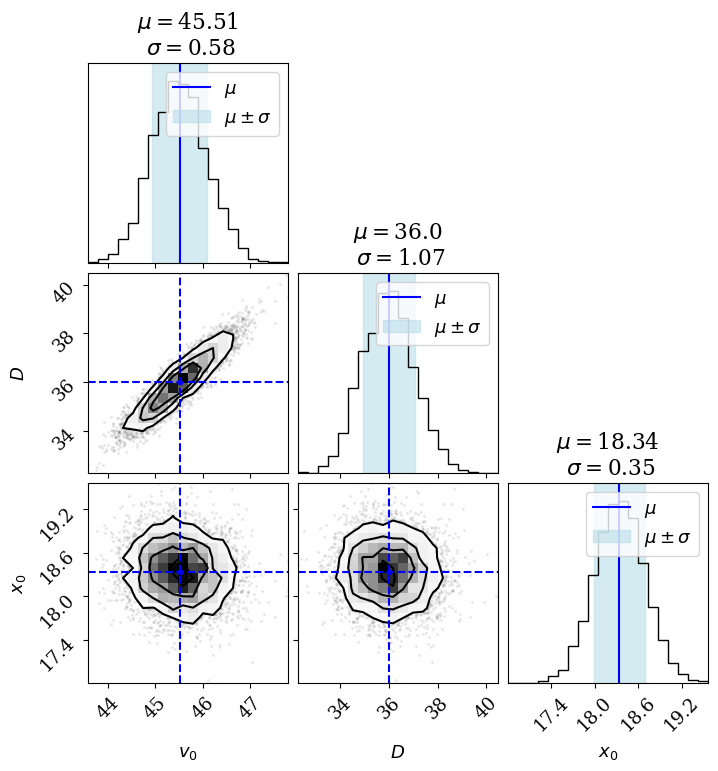

In [21]:
fig = corner.corner(pos, labels=["$v_{0}$", "$D$", "$x_{0}$"])


# Extract the axes
axes = np.array(fig.axes).reshape((ndim, ndim))

for ii in range(ndim):
    ax = axes[ii, ii]
    ax.axvline(np.mean(sampler.chain[:, :, ii]), label="$\mu$", color="blue")
    ax.axvspan(np.mean(sampler.chain[:, :, ii]) - np.std(sampler.chain[:, :, ii]), 
               np.mean(sampler.chain[:, :, ii])  + np.std(sampler.chain[:, :, ii]), 
               alpha=0.5,
               color="lightblue", 
               label="$\mu \pm \sigma$")
    ax.set_title("$\mu = $" + str(round(np.mean(sampler.chain[:, :, ii]), 2))
                 +"\n $\sigma = $" + str(round(np.std(sampler.chain[:,:, ii]), 2)))
    ax.legend()
    
# Loop over the histograms
for yi in range(ndim):
    for xi in range(ndim):
        if xi < yi:
            ax = axes[yi, xi]
            ax.axvline(np.mean(sampler.chain[:, :, xi]), color="blue", ls="--")
            ax.axhline(np.mean(sampler.chain[:, :, yi]), color="blue", ls="--")
            ax.scatter(np.mean(sampler.chain[:, :, xi]), np.mean(sampler.chain[:, :, yi]), color="blue", s=10)

## Diagnostics for MCMC

**1) Mixing of the Chain (Heuristic):**
Good mixing occurs when more of the domain is explored. Bad mixing occurs when the step size is too large and most proposals are rejected, resulting in less space being explored. 

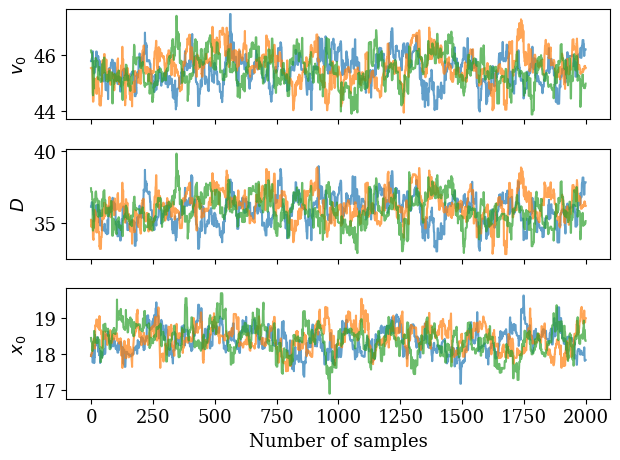

In [13]:
fig, ax = plt.subplots(nrows=3, sharex=True)
ax[0].plot(sampler.chain[::2000,:,0].T, '-', alpha=0.7)
ax[1].plot(sampler.chain[::2000,:,1].T, '-', alpha=0.7)
ax[2].plot(sampler.chain[::2000,:,2].T, '-', alpha=0.7)
ax[0].set_ylabel("$v_{0}$")
ax[1].set_ylabel("$D$")
ax[2].set_ylabel("$x_{0}$")
ax[2].set_xlabel("Number of samples")
plt.tight_layout()

**2) Autocorrelation:** Autocorrelation draws from the fundamental property of a Markov chain: *every Markov chain is memoryless*. We can compute the autocorrelation of states which are $\ell$ iterations apart as
$$
R(\ell) \equiv \frac{\sum_{i=1}^{n=\ell} (X_{i} -\bar{X})(X_{i+\ell} - \bar{X})}{\sum_{i=1}^{n} (X_{i} - \bar{X})^2}
$$
where $\bar{X}$ is the mean.

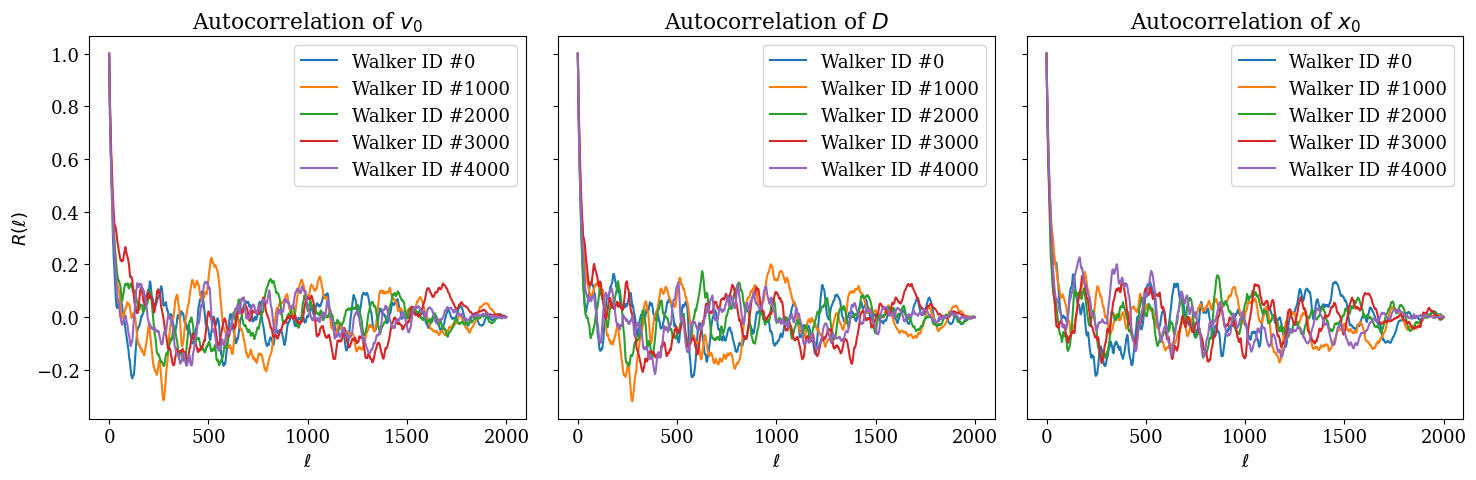

In [14]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(15, 5))
for jj in range(3):
    for ii in np.arange(0, nwalkers, 1000):
        ax[jj].plot(emcee.autocorr.function_1d(sampler.chain[ii, :, jj]), label="Walker ID #" + str(ii))
        ax[jj].legend()
        ax[jj].set_xlabel("$\ell$")
ax[0].set_title("Autocorrelation of $v_{0}$")
ax[1].set_title("Autocorrelation of $D$")
ax[2].set_title("Autocorrelation of $x_{0}$")
ax[0].set_ylabel("$R(\ell)$")
plt.tight_layout()

**3) Integrated Autocorrelation (IAC) and Effective Sample Size (ESS):** In standard MC, the variance of the estimator is 
$$
\mathbb{V}\text{ar} \left( \frac{1}{N} \sum_{i=1}^{N} f(X^{(i)})\right) = \frac{\mathbb{V}\text{ar}(f(X))}{N}, \qquad X^{(i)} \sim i.i.d.
$$
In MCMC, samples are correlated, so we get additional covariance terms. If we assume that all $X_{i}$ and $X_{j}$ are samples from the target distribution, then we can approximate the variance of the MCMC estimator as 
$$
\mathbb{V}\text{ar}\left(\bar{f}(X)^{\text{MCMC}}\right) = \mathbb{V}\text{ar} \left( \frac{1}{N} \sum_{i=1}^{N} f(X^{(i)})\right) = \frac{\mathbb{V}\text{ar}\left(f(X) \right)}{N} \cdot \theta
$$
where the integrated autocorrelation (IAC) $\theta$ is defined as 
$$
\theta = \sum_{\tau=-\infty}^{\infty} \rho_{f}(\tau)
$$
where $\rho_{f}(\tau)$ is the normalized autocorrelation function of the stochastic process that generated the chain for $f$. You can estimate $\rho_{f}(\tau)$ using a finite chain $\{ f_{n}\}_{n=1}^{N}$ as 
$$
\hat{\rho}_{f}(\tau) = \hat{c}_{f}(\tau)/\hat{c}_{f}(0)
$$
where 
$$
\hat{c}_{f}(\tau) = \frac{1}{N-\tau} \sum_{n=1}^{N-\tau} (f_{n} - \mu_{f}) (f_{n+\tau} - \mu_{f})
$$
and 
$$
\mu_{f} = \frac{1}{N} \sum_{n=1}^{N} f_{n}.
$$
We stimate $\theta$ using the estimator for $\rho_{f}(\tau)$ as 
$$
\theta(M) = 1 + 2 \sum_{\tau=1}^{M} \hat{\rho}_{f}(\tau)
$$
The effective sample size of MCMC is then $\frac{N}{\theta}$ and we want $\frac{N}{\theta} \ll 1$. Essentially, $\theta$ is the number of steps that are needed fbefore the chain "forgets" where it started. Once we estimate $\theta$ then we can estimate the number of samples that we need to generate to reduce the relative error on the target inegral. Typically, parallel chains longer than $50\theta$ are often sufficient. 

The integrated autocorrelation time is an estimate of the number of steps needed in the chain in order to draw independent samples from the target density. A more efficient chain has a shorter autocorrelation time.

In [15]:
theta = sampler.get_autocorr_time()
print(theta)

[32.5704329  32.65573955 32.34871601]


In [16]:
print("More than N=" + str(int(np.mean(theta)*50)) + " samples in each chain is sufficient.")

More than N=1626 samples in each chain is sufficient.


## Plot uncertainty estimates 

In [17]:
def sample_walkers(nsamples,flattened_chain, x, thinning):
    models = []
    for theta in flattened_chain[::thinning]:
        models.append(model(theta=theta, x=x))
    spread = np.std(models, axis=0)
    mean = np.mean(models, axis=0)
    return mean, spread, models

In [18]:
mean, spread, models = sample_walkers(nsamples=nsamples, 
                                      flattened_chain=sampler.flatchain, 
                                      x=data[:, 0], 
                                      thinning=200)

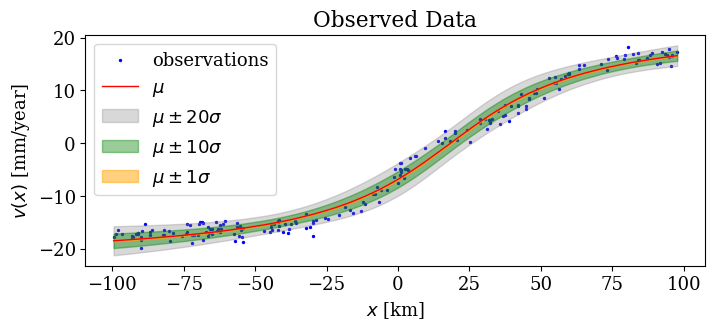

In [19]:
fig, ax = plt.subplots(figsize=(8, 3))
_ = ax.scatter(data[:, 0], data[:, 1], s=2, color="b", label="observations")
_ = ax.plot(np.sort(data[:, 0]), mean[np.argsort(data[:, 0])], linewidth=1, c="r", label='$\mu$')
_ = ax.fill_between(np.sort(data[:, 0]), 
                    mean[np.argsort(data[:, 0])]-20*spread[np.argsort(data[:, 0])], 
                    mean[np.argsort(data[:, 0])]+20*spread[np.argsort(data[:, 0])],
                    color='grey',
                    alpha=0.3,
                    label=r'$\mu \pm 20\sigma$')
_ = ax.fill_between(np.sort(data[:, 0]), 
                    mean[np.argsort(data[:, 0])]-10*spread[np.argsort(data[:, 0])], 
                    mean[np.argsort(data[:, 0])]+10*spread[np.argsort(data[:, 0])],
                    color='green',
                    alpha=0.4,
                    label=r'$\mu \pm 10\sigma$')
_ = ax.fill_between(np.sort(data[:, 0]), 
                    mean[np.argsort(data[:, 0])]-1*spread[np.argsort(data[:, 0])], 
                    mean[np.argsort(data[:, 0])]+1*spread[np.argsort(data[:, 0])],
                    color='orange',
                    alpha=0.5,
                    label=r'$\mu \pm 1\sigma$')
_ = ax.set_xlabel("$x$ [km]")
_ = ax.set_ylabel("$v(x)$ [mm/year]")
_ = ax.set_title("Observed Data")
_ = ax.legend()